In [18]:
#this function will help us in generating images which will help us in knowing what we are doing
from IPython.display import Image
#to get content from a web page we import HTML
from IPython.core.display import HTML 
#bridge gap between python 2 and python 3
from __future__ import print_function, division
#generate some binary input data
import numpy as np
import tensorflow as tf
#for plotting
import matplotlib.pyplot as plt
Image(url= "https://cdn-images-1.medium.com/max/1600/1*UkI9za9zTR-HL8uM15Wmzw.png")
#shows that RNN that is learning over time and 3 squares are hidden states. Hidden layers in RNN changes over time because we not just feed the input data, we feed input and the previous hidden state data
#so when we perform optimization(backpropogation) so it backprops through time and so it remembers what happened in the past.

In [19]:
#hyperparams

#number of times we want to train our network, inside epochs we have batches and it becomes a nested loop
num_epochs = 10 #more epochs longer train time better prediction, so its basically a tradeoff between time, accuracy and computation.
#how long sequence we want to generate
total_series_length = 50000
#this means that we are going to save portions of the sequence and we are going to discard the oldest values over time. Its similar to vanishing gradient problem, where we use keep_prob to keep certain part of network and drop rest of it while backpropogating.
truncated_backprop_length = 15
#number of neurons in our hidden layer, because we have 3 layer RNN that we are building and hidden state we are going to update over time.
state_size = 4
#since our data is binary and its not classification its sequence to sequence mapping. Classes: 0 and 1 so total:2
num_classes = 2
# to understand echo_step this might come in handy 
#https://stats.stackexchange.com/questions/140652/what-is-an-intuitive-explanation-of-echo-state-networks
echo_step = 3
#each time we consider window size of 5
batch_size = 5
#how many times we will have to iterate in order to train our model on complete 50000 sequence length
#you can also consider truncate as strides in CNN, so we skip some part of network.
num_batches = total_series_length//batch_size//truncated_backprop_length

In [20]:
#Step 1 - Collect data
#Now generate the training data, 
#the input is basically a random binary vector. The output will be the 
#“echo” of the input, shifted echo_step steps to the right.
#Lot of time we want to test out our Neural Networks but we do not want to test out on real world data so we generate data using numpy


#Notice the reshaping of the data into a matrix with batch_size rows. 
#Neural networks are trained by approximating the gradient of loss function 
#with respect to the neuron-weights, by looking at only a small subset of the data, 
#also known as a mini-batch.The reshaping takes the whole dataset and puts it into 
#a matrix, that later will be sliced up into these mini-batches.

def generateData():
    #We generate a time series data, we generate 50k samples all binary.
    #0,1, 50K samples, 50% chance each chosen
    #2 means 2 class 0 and 1. total_series is the length of the series we defined earlier and the probability that each of the classes get picked is 50-50.
    x = np.array(np.random.choice(2, total_series_length, p=[0.5, 0.5]))
    #shift times series 3 steps to the right
    # eg: x is 1-10 and echo_step is 3 so y will be 7 8 9 1 2 3 4 5 6 and in next step we pad the first 3 sequence with 0.
    # y is exact same series shifted to the right by 3 steps.
    y = np.roll(x, echo_step)
    #padd beginning 3 values with 0
    y[0:echo_step] = 0
    #Gives a new shape to an array without changing its data.
    #The reshaping takes the whole dataset and puts it into a matrix, 
    #that later will be sliced up into these mini-batches.
    x = x.reshape((batch_size, -1))  # The first index changing slowest, subseries as rows
    y = y.reshape((batch_size, -1))

    return (x, y)
#x and y are correlated with time.
#the purpose of all this is toshows how memory is incorporated in RNN.
data = generateData()

print(data)

(array([[0, 0, 0, ..., 1, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 1, 0, 0],
       [0, 1, 0, ..., 0, 1, 0],
       [1, 1, 1, ..., 1, 1, 1]]), array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 1, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 1, 1, 0],
       [0, 1, 0, ..., 1, 0, 1]]))


In [21]:
#Schematic of the reshaped data-matrix, arrow curves shows adjacent time-steps that ended up on different rows. 
#Light-gray rectangle represent a “zero” and dark-gray a “one”.
Image(url= "https://cdn-images-1.medium.com/max/1600/1*aFtwuFsboLV8z5PkEzNLXA.png")

In [22]:
#TensorFlow works by first building up a computational graph, that 
#specifies what operations will be done. The input and output of this graph
#is typically multidimensional arrays, also known as tensors. 
#The graph, or parts of it can then be executed iteratively in a 
#session, this can either be done on the CPU, GPU or even a resource 
#on a remote server.

#operations and tensors

#The two basic TensorFlow data-structures that will be used in this 
#example are placeholders and variables. On each run the batch data 
#is fed to the placeholders, which are “starting nodes” of the 
#computational graph. Also the RNN-state is supplied in a placeholder, 
#which is saved from the output of the previous run.

#point of reshaping tensor/array was so that we can feed it in to our placeholders which is a gateway through which data flows in to the tensorflow.


#Step 2 - Build the Model

#datatype, shape (5, 15) 2D array or matrix, batch size shape for later
#shape of X and Y are 2 D matrix, float32 since it is 32 bit float.
# we can consider echo to be a label, its a mapping between sequences.
batchX_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length])
batchY_placeholder = tf.placeholder(tf.int32, [batch_size, truncated_backprop_length])

#and one for the RNN state, 5,4 
#initialize the state, because we want to know what is happening in the memory portion of the hidden state.
#we feed in the state every time not just feeding the input data at every iteration of training we are also feeding in previous hidden states that we learnt.
#so this is the gateway for that hidden state.
#in RNN we have placeholders not just for I/P data and labels but also for the state that it learnt before.
#so its got a previous state and current state.
#so shape of it is going to be batch_size and number of neurons that happened before hand.
init_state = tf.placeholder(tf.float32, [batch_size, state_size])

In [23]:
#now we build our weights and biases as we have got our placeholders and we have defined our gateways, data is to ready to be fed in to the network.
#since it is a 3 layer RNN, we have 2 sets of weights between I/P and hidden layer and hidden layer and O/P.
#The weights and biases of the network are declared as TensorFlow variables,
#which makes them persistent across runs and enables them to be updated
#incrementally for each batch.

#3 layer recurrent net, one hidden state

#randomly initialize weights
#as we know variables can be updated over time unlike constants and placeholders.
#its better to initialize randomly than initializing as all zeros.
W = tf.Variable(np.random.rand(state_size+1, state_size), dtype=tf.float32)
#improves convergence, matrix of 0s
#in terms of linear regression y = mx + b, in non-linear model it still offers that anchor point of convergence.
#not that y intercept its just an anchor point so that the value we predict our not too far off from what it should be.
b = tf.Variable(np.zeros((1,state_size)), dtype=tf.float32)

W2 = tf.Variable(np.random.rand(state_size, num_classes),dtype=tf.float32)
b2 = tf.Variable(np.zeros((1,num_classes)), dtype=tf.float32)

In [24]:
Image(url= "https://cdn-images-1.medium.com/max/1600/1*n45uYnAfTDrBvG87J-poCA.jpeg")
#dotted square is looking at the batches.

In [25]:
#Now it’s time to build the part of the graph that resembles the actual RNN computation, 
#first we want to split the batch data into adjacent time-steps.

# Unstack columns
#Unstacks the given dimension of a rank-R tensor into rank-(R-1) tensors.
#so a bunch of arrays, 1 batch per time step
#we unstack the columns so that we can feed it in our array.
#it unstacks the columns in to a set of lists and each of these lists are going to be fed in, remember matrix 1's and 0's we just want 1 array at a time.
#unstack matrix in to a 1D array both for I/P and O/P series.
inputs_series = tf.unstack(batchX_placeholder, axis=1)
labels_series = tf.unstack(batchY_placeholder, axis=1)

In [26]:
Image(url= "https://cdn-images-1.medium.com/max/1600/1*f2iL4zOkBUBGOpVE7kyajg.png")
#Schematic of the current batch split into columns, the order index is shown on each data-point 
#and arrows show adjacent time-steps.

In [27]:
#Forward pass
#here we learn about memory and how it is incorporated in RNN.
#update placeholders over time, we can do this in our computation graph but we are going to do this before.
#state placeholder
#we define our curren state of hidden layer
current_state = init_state
# track series of states through time and store in this array
# this is how we remember the states we store in memory in an array.
states_series = []


#for each set of inputs
#forward pass through the network to get new state value
#store all states in memory
#for current input in input series for all inputs that we have defined before hand we are going to take the current I/P and we are going to feed it through the network.
for current_input in inputs_series:
    #format input, reshape it so that its in a shape that our RNN accepts, reshape cirrent_input in to batch_sie * 1.
    current_input = tf.reshape(current_input, [batch_size, 1])
    #mix both state and input data 
    input_and_state_concatenated = tf.concat([current_input, current_state],1)  # Increasing number of columns
    #before squashing the data with a non-linearity we perform matrix multiplication between weights and input, add bias
    #squash with a nonlinearity, for probabiolity value
    #tanh is mostly prefered in RNN, sigmoids are great for generating O/P probabilities. They are mostly seen at the end whether in CNN or RNN as it helps in describing our O/P probability.
    #sigmoid takes time to converge and tanh is faster.
    next_state = tf.tanh(tf.matmul(input_and_state_concatenated, W) + b)  # Broadcasted addition
    #now we append the list with the next state value and store the state in memory
    #so this list is going to be filled with sequence of learned hidden states. This is the memory aspect of RNN.
    #we are remembering each step through time.
    #remember every hidden state value and its not just it remembers it and throws them in to space, but it stores them in a list, stores them in to memory data structure.
    states_series.append(next_state)
    #then we set current state to next one
    #if you recall data structure and and algorithm this is very similar to linked list, where we set set head or current_pointer node to the current node's next part. Its logic is similar to that.
    current_state = next_state

In [28]:
Image(url= "https://cdn-images-1.medium.com/max/1600/1*fdwNNJ5UOE3Sx0R_Cyfmyg.png")
#concatenation occurs through matrix multiplication operation, then we multiply it by weights and add bias before squashing the input with a non linearity and we get a next state.
#we store all these states over time.

In [29]:
#calculate loss
#second part of forward pass
#logits short for logistic transform
#its outputs values that we are going to squash at very end with a softmax which is going to give us a prediction.
logits_series = [tf.matmul(state, W2) + b2 for state in states_series] #Broadcasted addition
#apply softmax nonlinearity for output probability, prediction_series is the ending non-linearity, basically list of all our predictions over time. 
predictions_series = [tf.nn.softmax(logits) for logits in logits_series]

#measure loss, calculate softmax again on logits, then compute cross entropy
#measures the difference between two probability distributions and that difference we have to minimise
#this will return A Tensor of the same shape as labels and of the same type as logits 
#with the softmax cross entropy loss.
#In our example the classes are mutually exclusive (they are either zero or one), 
#which is the reason for using the “Sparse-softmax”.
losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels) for logits, labels in zip(logits_series,labels_series)]
#computes average, gives one value which is total loss after 1 forward pass that we want to minimise.
total_loss = tf.reduce_mean(losses)
#use adagrad to minimize with 0.3 learning rate
#minimize it with adagrad, not SGD
#One downside of SGD is that it is sensitive to
#the learning rate hyper-parameter. When the data are sparse and features have
#different frequencies, a single learning rate for every weight update can have
#exponential regret.
#sometimes features that are very important and for some reason our Neural Network does not weigh them properly.
#because it uses same learning rate across all features, may be because its sparse data, but sometimes sparse features can also be very important to us.
#Some features can be extremely useful and informative to an optimization problem but 
#they may not show up in most of the training instances or data. If, when they do show up, 
#they are weighted equally in terms of learning rate as a feature that has shown up hundreds 
#of times we are practically saying that the influence of such features means nothing in the 
#overall optimization. it's impact per step in the stochastic gradient descent will be so small 
#that it can practically be discounted). To counter this, AdaGrad makes it such that features 
#that are more sparse in the data have a higher learning rate which translates into a larger 
#update for that feature
#sparse features can be very useful.
#Each feature has a different learning rate which is adaptable. 
#gives voice to the little guy who matters a lot
#weights that receive high gradients will have their effective learning rate reduced, 
#while weights that receive small or infrequent updates will have their effective learning rate increased. 
#great paper http://seed.ucsd.edu/mediawiki/images/6/6a/Adagrad.pdf
train_step = tf.train.AdagradOptimizer(0.3).minimize(total_loss)

In [30]:
#visualizer
#plots training input, training output and current predictions of our network.
def plot(loss_list, predictions_series, batchX, batchY):
    plt.subplot(2, 3, 1)
    plt.cla()
    plt.plot(loss_list)

    for batch_series_idx in range(5):
        one_hot_output_series = np.array(predictions_series)[:, batch_series_idx, :]
        single_output_series = np.array([(1 if out[0] < 0.5 else 0) for out in one_hot_output_series])

        plt.subplot(2, 3, batch_series_idx + 2)
        plt.cla()
        plt.axis([0, truncated_backprop_length, 0, 2])
        left_offset = range(truncated_backprop_length)
        plt.bar(left_offset, batchX[batch_series_idx, :], width=1, color="blue")
        plt.bar(left_offset, batchY[batch_series_idx, :] * 0.5, width=1, color="red")
        plt.bar(left_offset, single_output_series * 0.3, width=1, color="green")

    plt.draw()
    plt.pause(0.0001)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


New data, epoch 0
Step 0 Loss 0.904281
Step 100 Loss 0.575372
Step 200 Loss 0.0231487
Step 300 Loss 0.00871894
Step 400 Loss 0.00549712
Step 500 Loss 0.00396285
Step 600 Loss 0.00318456
New data, epoch 1
Step 0 Loss 0.201201
Step 100 Loss 0.00286406
Step 200 Loss 0.00390953
Step 300 Loss 0.00260404
Step 400 Loss 0.00210368
Step 500 Loss 0.00166749
Step 600 Loss 0.00143025
New data, epoch 2
Step 0 Loss 0.263851
Step 100 Loss 0.00148293
Step 200 Loss 0.0012379
Step 300 Loss 0.00113345
Step 400 Loss 0.000945695
Step 500 Loss 0.000888742
Step 600 Loss 0.000914599
New data, epoch 3
Step 0 Loss 0.275884
Step 100 Loss 0.000916197
Step 200 Loss 0.000917977
Step 300 Loss 0.000744618
Step 400 Loss 0.000842856
Step 500 Loss 0.000650454
Step 600 Loss 0.000657852
New data, epoch 4
Step 0 Loss 0.372089
Step 100 Loss 0.000758856
Step 200 Loss 0.000594098
Step 300 Loss 0.000622839
Step 400 Loss 0.000553201
Step 500 Loss 0.000504755
Step 600 Loss 0.000504445
New data, epoch 5
Step 0 Loss 0.257277
Step 

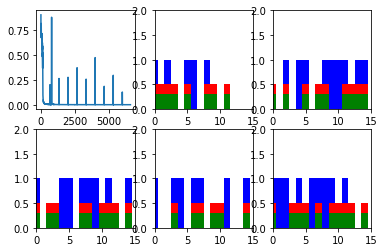

In [31]:
#Step 3 Training the network
##this is a class that runs all the tensorflow operations and launches the graph in a session. 
#All the operations have to be within the indentation. 
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    #interactive mode
    plt.ion()
    #initialize the figure
    plt.figure()
    #show the graph
    plt.show()
    #to show the loss decrease over time
    loss_list = []

    for epoch_idx in range(num_epochs):
        #generate data at every epoch, batches run in epochs
        #output binary sequences will be a copy but shifted over echo.
        x,y = generateData()
        #initialize an empty hidden state
        _current_state = np.zeros((batch_size, state_size))

        print("New data, epoch", epoch_idx)
        #each batch
        for batch_idx in range(num_batches):
            #starting and ending point per batch
            #since weights reoccur at every layer through time
            #These layers will not be unrolled to the beginning of time, 
            #that would be too computationally expensive, and are therefore truncated 
            #at a limited number of time-steps
            #so it remembers the most recent hidden state and not all previous states.
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length

            batchX = x[:,start_idx:end_idx]
            batchY = y[:,start_idx:end_idx]
            
            #run the computation graph, give it the values
            #we calculated earlier
            _total_loss, _train_step, _current_state, _predictions_series = sess.run(
                [total_loss, train_step, current_state, predictions_series],
                feed_dict={
                    batchX_placeholder:batchX,
                    batchY_placeholder:batchY,
                    init_state:_current_state
                })

            loss_list.append(_total_loss)

            if batch_idx%100 == 0:
                print("Step",batch_idx, "Loss", _total_loss)
                plot(loss_list, _predictions_series, batchX, batchY)

plt.ioff()
plt.show()

In [ ]:
#Blue bars denote a training input signal (binary one), 
#red bars show echos in the training output 
#and green bars are the echos the net is generating. 
#The different bar plots show different sample series in the current batch.

In [32]:
Image(url= "https://cdn-images-1.medium.com/max/1600/1*uKuUKp_m55zAPCzaIemucA.png")
#Time series of squares, the elevated black square symbolizes an echo-output, which is activated 
#three steps from the echo input (black square). 
#The sliding batch window is also striding three steps at each run, 
#which in our sample case means that no batch will encapsulate the dependency, so it can not train.

In [33]:
Image(url= "https://cdn-images-1.medium.com/max/1600/1*ytquMdmGMJo0-3kxMCi1Gg.png")
#Visualization of the loss, input and output training data (blue, red) as well as the prediction (green).
#The reason for the spikes is that we are starting on a new epoch, 
#and generating new data. Since the matrix is reshaped, 
#the first element on each row is adjacent to the last element in the previous row. 
#The first few elements on all rows (except the first) have dependencies 
#that will not be included in the state, so the net will always perform badly on the first batch.